# Логичтическая регрессия, метод опорных векторов, one-hot кодирование

### О задании

В этом задании вы изучите методы работы с категориальными переменными

In [17]:
%pylab inline
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


__Задание 1.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.

**(2 балла)**


Загрузим данные с конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [18]:
import pandas as pd
import numpy as np
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [19]:
from sklearn.model_selection import train_test_split
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучите логистическую регрессию с удобными для вас параметрами, примените регуляризацию, найдтие оптимум. Сделайте предсказание на тестовой части выборки. Замерьте качество.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

lreg_model = LogisticRegression(
    penalty="l2", C=1.0, solver="newton-cg", max_iter=30000, random_state=239
)

lreg_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=30000, random_state=239, solver='newton-cg')

In [22]:
y_pred = lreg_model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"acc: {acc:.4f}")
print(f"f1: {f1:.4f}")


acc: 0.5880
f1: 0.5715


__Выводы__ в свободной форме:

acc 0.58, получилось чуть чуть лучше сллучайного угадывания, но тут нет категориальных признаков

__Задание 2.__ Изучение влияния регуляризатора на процесс обучения

__(2 балла)__

Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
def loss(model, X, y, C):
    # log_loss не учитывает регуляризацию
    y_pred_prob = model.predict_proba(X)
    llos = log_loss(y, y_pred_prob)
    return llos

def train_iter(X_train, y_train, X_test, y_test, C, iter):
    model = LogisticRegression(
        penalty="l2",
        C=C,
        solver="newton-cg",
        max_iter=1,
        warm_start=True,
        random_state=239,
    )

    train_losses = []
    test_losses = []

    for i in range(iter):
        model.fit(X_train, y_train)
        train_losses.append(loss(model, X_train, y_train, C=C))
        test_losses.append(loss(model, X_test, y_test, C=C))

    return train_losses, test_losses

In [24]:
iter = 50

train_azero, test_azero = train_iter(X_train_scaled, y_train, X_test_scaled, y_test, C=1e18, iter=iter)
train_a, test_a = train_iter(X_train_scaled, y_train, X_test_scaled, y_test, C=0.1, iter=iter)


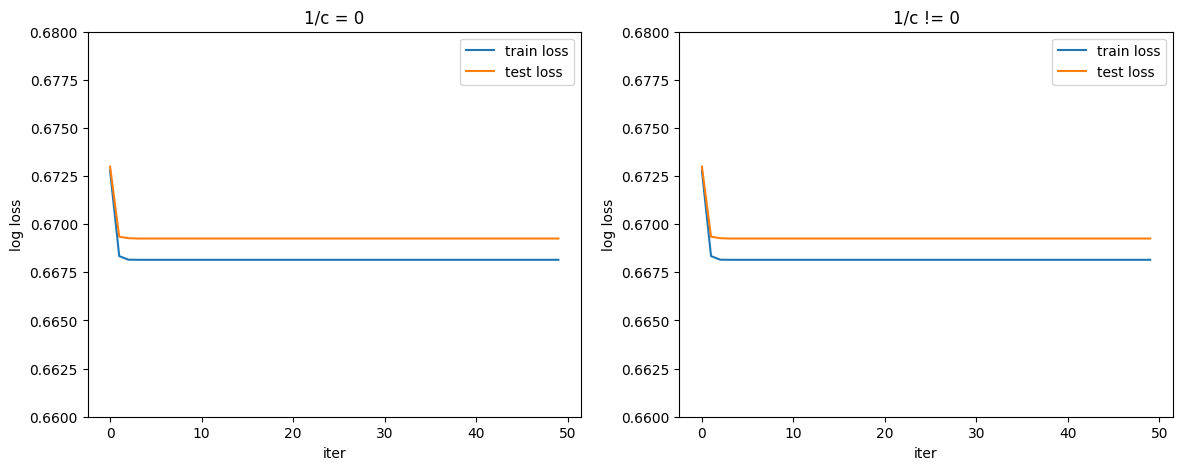

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))


plt.subplot(1,2,1)
plt.plot(train_azero, label='train loss')
plt.plot(test_azero, label='test loss')
plt.title("1/c = 0")
plt.xlabel("iter")
plt.ylabel("log loss")
plt.ylim(0.66, 0.68) 
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_a, label='train loss')
plt.plot(test_a, label='test loss')
plt.title("1/c != 0")
plt.xlabel("iter")
plt.ylabel("log loss")
plt.ylim(0.66, 0.68)  
plt.legend()

plt.show()


__Выводы:__
я очень долго пытался подобрать солвер и количество данных + количество итераций, чтоб график вел себя нормально (loss на обучающей уменьшался, подошел только ньютон)
можно заметить, что без регуляризатора в какой-то момент модель переобучается. trasin loss падает, а test loss растет


если брать 10000 строчек, то данные сбалансированны и он сразу норм обучается и loss = const, если брать солвер saga, то она рандомно угадывает норм решение, а потом спускается куда-то не туда, liblinear не умеет по одной итерации обучаться, lbfgs тоже очень странно себя ведёт, но я хз как он работает

АПДЕЙТ я потерял размер, где что-то различатеся, теперь график не зависит от С, вероятно потому что ньютон очень быстро сходится и С как-то не очень влияет

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.

__(3 балла)__

In [26]:
categorical_cols = [c for c in data.columns if 'cat' in c]

data_onehot = pd.get_dummies(data, columns=categorical_cols)

print("bef one hot", data.shape)
print("after one-hot:", data_onehot.shape)

bef one hot (200000, 57)
after one-hot: (200000, 226)


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

__(2 балла)__

In [27]:
# Your code here
# ...

__Вывод:__

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков).

__Задание 3.__ Реализуйте корректное вычисление счётчиков двумя из трех вышеперчисленных способов, сравните. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(3 балла)__

In [28]:
# Your code here
# ...

__Вывод:__